## Useful Imports

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split

## Load Dataset file

In [7]:
imdb_dataset = pd.read_csv('IMDB Dataset.csv')

## Explore Data

In [11]:
imdb_dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [12]:
imdb_dataset.tail()

,review,sentiment
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative
49999,No one expects the Star Trek movies to be high...,negative


In [9]:
imdb_dataset.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [10]:
imdb_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


### Visualize the distribution of sentiment labels (Positive and Negative)

<AxesSubplot:title={'center':'Distribution of Sentiment Labels'}, xlabel='sentiment', ylabel='count'>

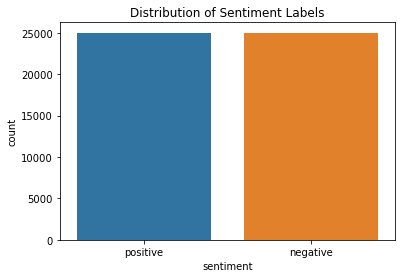

In [15]:
plt.title('Distribution of Sentiment Labels')
sns.countplot(data=imdb_dataset, x='sentiment')

We see that the number of instances in the the two sentiment labels (Positive and Negative) are roughly the same, so this means that it is a balanced dataset and there is no class imbalance problem here, and we can use **Accuracy** as the performance metric

In [19]:
X = imdb_dataset.drop(columns=['sentiment'])
y = imdb_dataset[['sentiment']]

In [34]:
# divide the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('The shape of X_train is', X_train.shape, 'and the shape of y_train is', y_train.shape)
print('The shape of X_test is', X_test.shape, 'and the shape of y_test is', y_test.shape)

The shape of X_train is (40000, 1) and the shape of y_train is (40000, 1)
The shape of X_test is (10000, 1) and the shape of y_test is (10000, 1)
